# Model Sensitivity

*Code to create Figure 3g in [Saliency Cards: A Framework to Characterize and Compare
Saliency Methods](https://arxiv.org/abs/2206.02958).*

Model sensitivity measures if the output of a saliency method is sensitive to meaningful changes to the model parameters. If we modify the model significantly (e.g., by randomizing its weights), then the output of a model sensitive saliency method will also reflect that change.

To illustrate model sensitivity, we show how [SmoothGrad](https://arxiv.org/abs/1706.03825) saliency maps look progressively random as we progressively randomize the model weights. This follows the *model parameter randomization test* from [Sanity Checks for Saliency Maps](https://arxiv.org/pdf/1810.03292.pdf).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from interpretability_methods.util import visualize_saliency
from interpretability_methods.vanilla_gradients import VanillaGradients
from util import imagenet_transform, load_model_from_pytorch, load_pil_image

## Load ImageNet Image and ResNet50 Model
In this example we compute the saliency of a ResNet50 model pretrained on ImageNet. We will analyze the saliency for the trained model, partially weight-randomized model, and fully randomized model.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = load_model_from_pytorch('resnet50', True, device).eval()
random_model = load_model_from_pytorch('resnet50', False, device).eval()

In [4]:
def initialize_parameters(module):
    """Randomly initialize the weights and bias of the module."""
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(module, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)

def randomly_init_layers(model, layer_prefixes):
    """Randomly initialize layers of the model."""
    for name, module in model.named_modules():
        for layer_name in layer_prefixes:
            if name.startswith(layer_name) or name.startswith(f'module.{layer_name}'):
                initialize_parameters(module)
                
partially_randomized_model = load_model_from_pytorch('resnet50', True, device).eval()
randomly_init_layers(partially_randomized_model, ['layer4']) # randomize the last layer
partially_randomized_model = partially_randomized_model.to(device).eval()

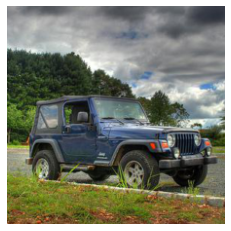

In [5]:
image_path = './resources/jeep.jpeg'
image = load_pil_image(image_path)

model_transform = imagenet_transform(normalize=True)
display_transform = imagenet_transform(normalize=False)

image_input = model_transform(image)
plt.imshow(display_transform(image).numpy().transpose(1, 2, 0))
plt.axis('off');

In [9]:
image_batch = image_input.unsqueeze(0).to(device)

## Compute SmoothGrad Saliency On Progressive Model Randomization
We apply [SmoothGrad](https://arxiv.org/abs/1706.03825) to a trained model, randomized model, and partially randomized model.

First, the trained model.

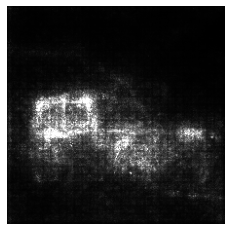

In [13]:
vg_trained = VanillaGradients(trained_model)
trained_saliency = vg_trained.get_saliency_smoothed(image_batch)
visualize_saliency(trained_saliency);

Then, a model that is partially randomized (all of ResNet50 layer 4).

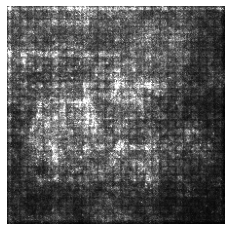

In [11]:
vg_partially_randomized = VanillaGradients(partially_randomized_model)
partially_randomized_saliency = vg_partially_randomized.get_saliency_smoothed(image_batch)
visualize_saliency(partially_randomized_saliency); # layer 4

Finally, the random model.

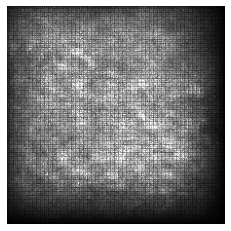

In [12]:
vg_random = VanillaGradients(random_model)
random_saliency = vg_random.get_saliency_smoothed(image_batch)
visualize_saliency(random_saliency);